<b> <font size="+2.5"> Differential expression analysis using dreamlet in full pseudobulk data
 </b> </font> <br>

Author: ASF <br>
Date: 2024-01-05

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(SingleCellExperiment)
library(zellkonverter)
library(dreamlet)
library(zenith)
library(DelayedArray)
library(GSEABase)
library(cowplot)
library(tidyverse)
library(kableExtra)
library(qvalue)
library(scattermore)
library(RColorBrewer)
library(corrplot)
library(viridis)
library(dplyr)
library(org.Hs.eg.db)
library(EnrichmentBrowser)
library(ggrepel)
library(rhdf5)
library(HDF5Array)
library(gridExtra)
library(grid)
library(readxl)
library(writexl)
})

# Read in anndata object and make pseudobulk

## read h5ad file

In [2]:
file <- "../datasets/adata_celltypes_after_manual_curation_20231120.h5ad"
sce <- readH5AD(file, use_hdf5=TRUE, verbose=FALSE)

Warning message:
“The names of these selected uns items have been modified to match R
conventions: '6-Batch_colors' -> 'X6.Batch_colors'”
Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”


In [3]:
#add column with full_pseudobulk label
sce$full_pseudobulk <- 'full_pseudobulk'

# Set missing RIN to median
sce$RIN[is.na(sce$RIN)] = median(sce$RIN, na.rm=TRUE) 

#formating
sce$Status <- as.factor(as.character(sce$Status))
sce$Status <- factor(sce$Status, c('0','1'))

sce$X6.Batch <- as.character(sce$X6.Batch)

sce$Disease_Status <- ifelse(sce$Status=='0', 'Controls', 'Cases')
sce$Disease_Status <- factor(sce$Disease_Status, levels=c('Controls', 'Cases'))

## compute pseudobulk

In [4]:
# counts here should represent the raw counts
pb <- aggregateToPseudoBulk(sce,
    assay = "counts",     
    cluster_id = "full_pseudobulk",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

In [5]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")
#this table needs to be in the same order (individual) as colData
# check: 
unique(colData(pb)$individual == PC1$individual)

[1] TRUE

In [6]:
pb$PC1 <- PC1$PC1_hidden_noise
#pb@colData
#pb

# Process data: log2 CPM + voom precision weights

## Normalization

In [7]:
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

res.proc <- processAssays(pb, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

  full_pseudobulk...
4.7 mins



In [8]:
# view details
details(res.proc)

assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
full_pseudobulk,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,22132,0,FALSE


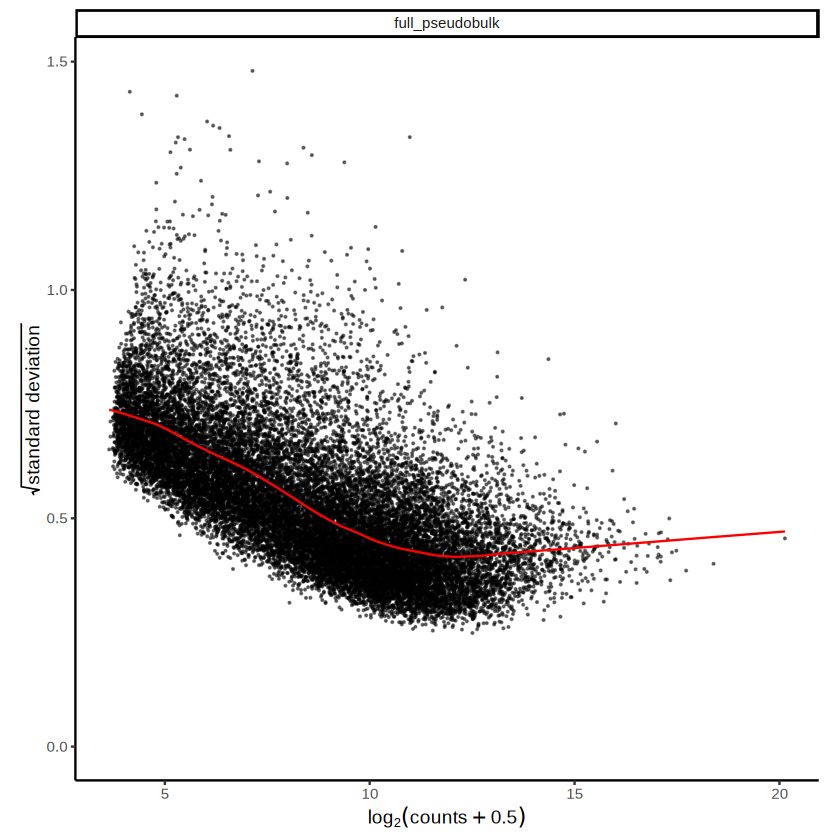

In [9]:
### Show voom-style mean-variance trends
plotVoom(res.proc)

# Variance partitioning

In [10]:
# run variance partitioning analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.vp <- fitVarPart(res.proc, form, BPPARAM = SnowParam(12))

  full_pseudobulk...
1.9 mins






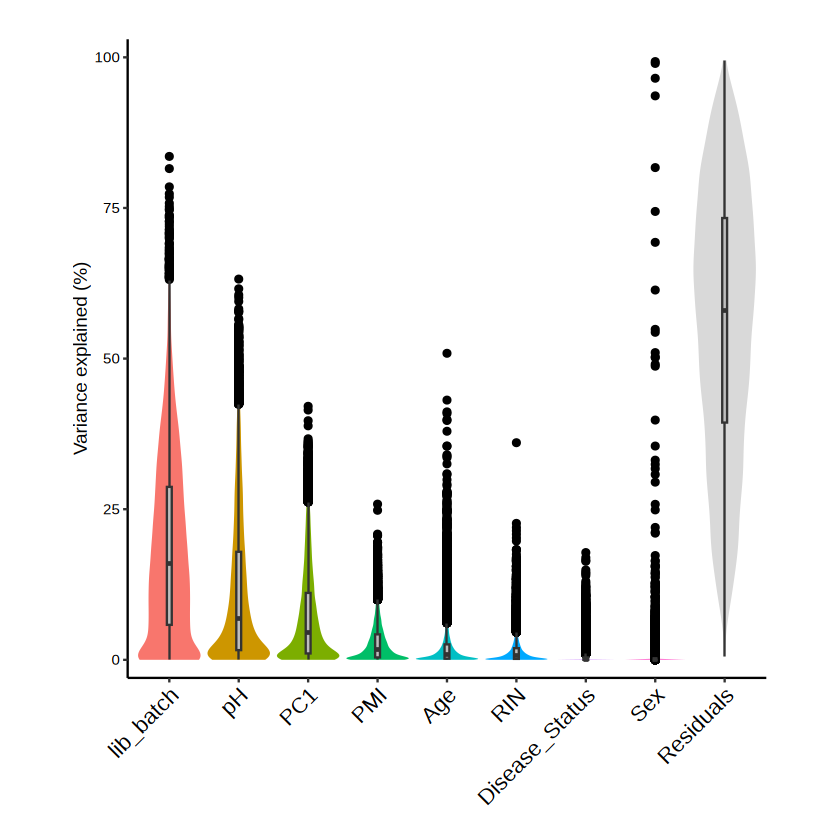

In [11]:
#colnames(res.vp)
colnames(res.vp)[colnames(res.vp) == "X6.Batch"] <- 'lib_batch'
colnames(res.vp)[colnames(res.vp) == "Brain.pH"] <- 'pH'
 
plotVarPart( sortCols(res.vp), label.angle=45 )

# Differential Gene Expression Analysis

## Age

In [12]:
# 20 mins
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

fit <- dreamlet(res.proc, form, BPPARAM = SnowParam(12))

  full_pseudobulk...
20 mins


Of 22,132 models fit across all assays, 0.836% failed




In [13]:
df_de_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0)
df_de_Age

nGenes_tested,nDE_0.1,nDE_0.05,pi1
<int>,<int>,<int>,<dbl>
21947,2604,1520,0.388963


Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


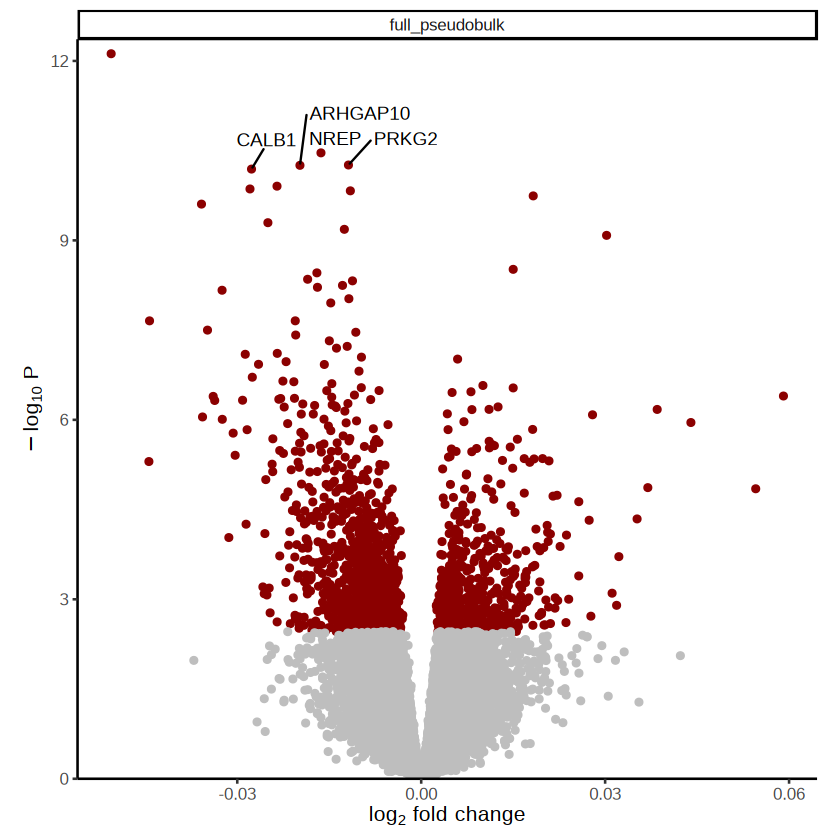

In [14]:
plotVolcano(fit, coef = "Age")

In [17]:
DE_results_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble

DE_results_Age <- as.data.frame(DE_results_Age)

In [19]:
library(writexl)
write_xlsx(DE_results_Age, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_full_pseudobulk.xlsx", col_names = TRUE)

## Supplementary Table 8

In [2]:
library(readxl)
library(dplyr)
DE_results_Age <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_full_pseudobulk.xlsx', col_names = TRUE))

# read in the gene information from adata object to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')

DE_results_Age <- merge(DE_results_Age, gene_names_ensembl, by='ID')
DE_Age_bulk <- DE_results_Age %>% select(c('assay','ID', 'ensembl', 'logFC','AveExpr','t','P.Value','adj.P.Val','B','z.std' ))
head(DE_Age_bulk)

,assay,ID,ensembl,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,full_pseudobulk,A1BG,ENSG00000121410,-0.003021176,2.485600,-1.1712096,0.24544493,0.5226981,-7.670889,-1.1614845
2,full_pseudobulk,A1BG-AS1,ENSG00000268895,0.001147263,2.931318,0.4720771,0.63819518,0.8266963,-8.326719,0.4702237
3,full_pseudobulk,A2M,ENSG00000175899,-0.005526960,3.516215,-1.1316836,0.26155860,0.5382491,-7.898247,-1.1227149
4,full_pseudobulk,A2M-AS1,ENSG00000245105,0.002866440,1.435576,0.9468714,0.34668295,0.6205571,-7.687940,0.9410428
5,full_pseudobulk,A2ML1,ENSG00000166535,0.001352426,1.861194,0.3063848,0.76017251,0.8922485,-8.159677,0.3052543
6,full_pseudobulk,A2ML1-AS1,ENSG00000256661,0.003657540,2.954731,2.0001482,0.04922565,0.2229375,-6.458229,1.9666320


In [3]:
library(writexl)
write_xlsx(DE_Age_bulk, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_w_ensembl_full_pseudobulk.xlsx", col_names = TRUE)

In [4]:
df_de_Age <- DE_Age_bulk %>%
    as_tibble %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0)
df_de_Age

nGenes_tested,nDE_0.1,nDE_0.05,pi1
<int>,<int>,<int>,<dbl>
21947,2604,1520,0.388963


# Overlap with previously published bulk studies

## read in Age DE results from this study

In [2]:
#full pseudobulk

# read in the gene information to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
#head(gene_names_ensembl)

# read in DE results and add ensembl ID
DE_genes_Age <- read_excel("../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_full_pseudobulk.xlsx", col_names = TRUE)
#merge gene ID and ensembl ID
DE_genes_Age <- merge(DE_genes_Age, gene_names_ensembl, by='ID')
head(DE_genes_Age)

# select significant genes and split in up- & downregulated
DE_genes_FDR0.05 <- DE_genes_Age[DE_genes_Age$adj.P.Val < 0.05, ]
Age_up <- DE_genes_Age[DE_genes_Age$logFC >0 & DE_genes_Age$adj.P.Val < 0.05, ]
Age_down <- DE_genes_Age[DE_genes_Age$logFC <0  & DE_genes_Age$adj.P.Val < 0.05, ]
dim(Age_up) # 522
dim(Age_down) #998

,ID,assay,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,ensembl
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A1BG,full_pseudobulk,-0.003021176,2.485600,-1.1712096,0.24544493,0.5226981,-7.670889,-1.1614845,ENSG00000121410
2,A1BG-AS1,full_pseudobulk,0.001147263,2.931318,0.4720771,0.63819518,0.8266963,-8.326719,0.4702237,ENSG00000268895
3,A2M,full_pseudobulk,-0.005526960,3.516215,-1.1316836,0.26155860,0.5382491,-7.898247,-1.1227149,ENSG00000175899
4,A2M-AS1,full_pseudobulk,0.002866440,1.435576,0.9468714,0.34668295,0.6205571,-7.687940,0.9410428,ENSG00000245105
5,A2ML1,full_pseudobulk,0.001352426,1.861194,0.3063848,0.76017251,0.8922485,-8.159677,0.3052543,ENSG00000166535
6,A2ML1-AS1,full_pseudobulk,0.003657540,2.954731,2.0001482,0.04922565,0.2229375,-6.458229,1.9666320,ENSG00000256661


[1] 522  10

[1] 998  10

## Gonzalez-Velasco et al. 2020

Gonzalez-Velasco et al. 2020 <br> DOI: https://doi.org/10.1016/j.bbagrm.2020.194491

In [3]:
# read in results from Gonzalez-Velasco et al. 2020¶
#Supplementary Table 2S. Aging signature of human brain cortex including 1148 genes
#table contains 1148 genes selected as significant in the analyses done over 3 independent datasets

Gonzalez_Age_genes <- read_excel("../external_datasets/Gonzalez_Velasco_et_al._SupplementaryTable2S.xlsx", col_names=T)
dim(Gonzalez_Age_genes)[1]

#split in up- and downregulated genes
Gonzalez_Age_up <- Gonzalez_Age_genes[Gonzalez_Age_genes$meanGamma_dts134 >0,]
Gonzalez_Age_down <- Gonzalez_Age_genes[Gonzalez_Age_genes$meanGamma_dts134 <0,]
dim(Gonzalez_Age_up)[1]
dim(Gonzalez_Age_down)[1]

[1] 1148

[1] 456

[1] 692

In [4]:
# filter out genes not expressed in this study from Gonzalez dataset then perform overlap
Gonzalez_Age_up <- Gonzalez_Age_up[Gonzalez_Age_up$ENSEMBL_geneID %in% DE_genes_Age$ensembl ,]
dim(Gonzalez_Age_up)[1] #435
Gonzalez_Age_down <- Gonzalez_Age_down[Gonzalez_Age_down$ENSEMBL_geneID %in% DE_genes_Age$ensembl,]
dim(Gonzalez_Age_down)[1] #680

[1] 435

[1] 680

In [5]:
######
# Perform gene overlap
######
library(GeneOverlap)

# for Age upregulated genes

overlap_up_Gonzalez <-  newGeneOverlap(Gonzalez_Age_up$ENSEMBL_geneID, Age_up$ensembl, genome.size=length(DE_genes_Age$ensembl))

overlap_up_Gonzalez_stats <- testGeneOverlap(overlap_up_Gonzalez)

overlap_Gonzalez_up_table <- as.data.frame(matrix(ncol=7, nrow=1))
colnames(overlap_Gonzalez_up_table) <- c('Age DE genes Gonzalez et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio', 'direction' )

overlap_Gonzalez_up_table$`Age DE genes Gonzalez et al.` <- length(overlap_up_Gonzalez_stats@listA)
overlap_Gonzalez_up_table$`Age DE genes Fröhlich et al.` <- length(overlap_up_Gonzalez_stats@listB)
overlap_Gonzalez_up_table$`n overlap genes` <- length(overlap_up_Gonzalez_stats@intersection)
overlap_Gonzalez_up_table$`Genome size` <- overlap_up_Gonzalez_stats@genome.size
overlap_Gonzalez_up_table$`overlap p-value` <- overlap_up_Gonzalez_stats@pval
overlap_Gonzalez_up_table$`Odds Ratio` <- overlap_up_Gonzalez_stats@odds.ratio
overlap_Gonzalez_up_table$direction <- 'up'

In [6]:
# for Age downregulated genes
overlap_down_Gonzalez <-  newGeneOverlap(Gonzalez_Age_down$ENSEMBL_geneID, Age_down$ensembl, genome.size=length(DE_genes_Age$ensembl))

overlap_down_Gonzalez_stats <- testGeneOverlap(overlap_down_Gonzalez)

overlap_Gonzalez_down_table <- as.data.frame(matrix(ncol=7, nrow=1))
colnames(overlap_Gonzalez_down_table) <- c('Age DE genes Gonzalez et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio', 'direction' )

overlap_Gonzalez_down_table$`Age DE genes Gonzalez et al.` <- length(overlap_down_Gonzalez_stats@listA)
overlap_Gonzalez_down_table$`Age DE genes Fröhlich et al.` <- length(overlap_down_Gonzalez_stats@listB)
overlap_Gonzalez_down_table$`n overlap genes` <- length(overlap_down_Gonzalez_stats@intersection)
overlap_Gonzalez_down_table$`Genome size` <- overlap_down_Gonzalez_stats@genome.size
overlap_Gonzalez_down_table$`overlap p-value` <- overlap_down_Gonzalez_stats@pval
overlap_Gonzalez_down_table$`Odds Ratio` <- overlap_down_Gonzalez_stats@odds.ratio
overlap_Gonzalez_down_table$direction <- 'down'

## Supplementary Table 9a

In [7]:
overlap_Gonzalez_table <- rbind(overlap_Gonzalez_up_table, overlap_Gonzalez_down_table)
overlap_Gonzalez_table

Age DE genes Gonzalez et al.,Age DE genes Fröhlich et al.,n overlap genes,Genome size,overlap p-value,Odds Ratio,direction
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
435,522,78,21947,1.476691e-45,10.36207,up
680,998,237,21947,5.168094e-149,14.41081,down


In [8]:
write_xlsx(overlap_Gonzalez_table, path = "../results/bulk_overlap_other_datasets/Gonzalez_overlap_results.xlsx", col_names = TRUE)

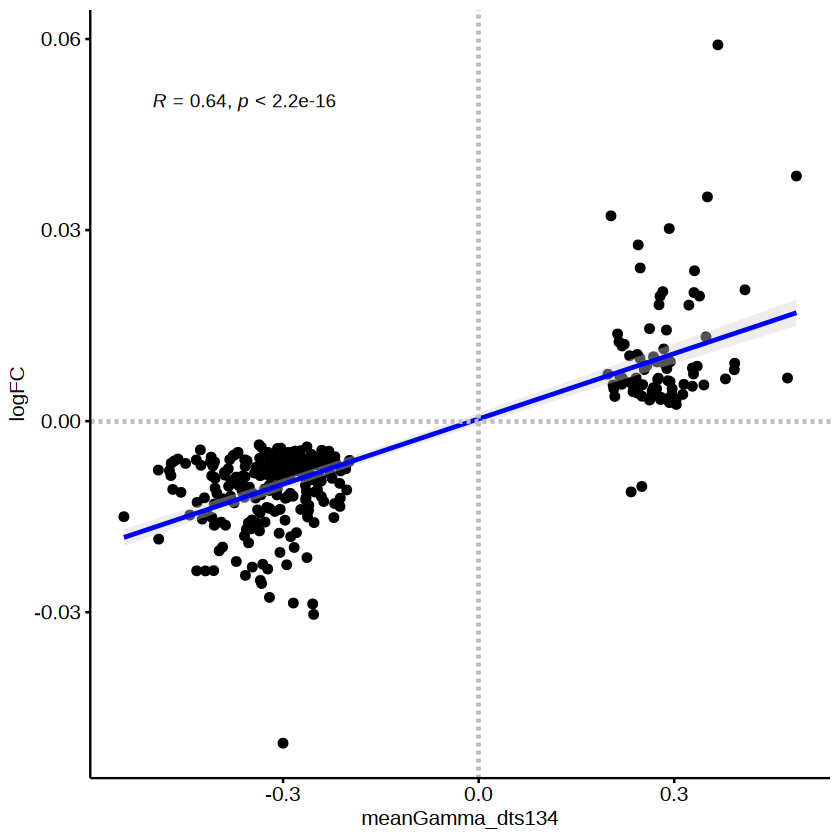

In [9]:
# Spearman correlation of fold change
# this study: logFC per year
# Gonzalez et al.: meanGamma_dts134 
#(gamma correlation: non-parametric coefficient that measures the relationship between ordinal variables)
colnames(Gonzalez_Age_genes)[which(names(Gonzalez_Age_genes) == 'ENSEMBL_geneID')] <- 'ensembl'

combined <- merge(Gonzalez_Age_genes, DE_genes_FDR0.05, by='ensembl')

suppressPackageStartupMessages({library(ggpubr)})
sp <- ggscatter(combined, x = "meanGamma_dts134", y = "logFC",
   add = "reg.line",  # Add regressin line
   add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
   conf.int = TRUE # Add confidence interval
   )
# Add correlation coefficient
sp + stat_cor(method = "spearman", label.x = -0.5, label.y = 0.05) + 
geom_hline(yintercept=0, linetype="dashed", color = "grey", linewidth=1) + 
geom_vline(xintercept=0, linetype="dashed", color = "grey", linewidth=1)

## Kumar et al. 2013

Kumar et al. 2013 <br>
https://doi.org/10.1016/j.neurobiolaging.2012.10.021

In [10]:
# read in Kumar et a. age regulated genes 
# use only genes from frontal regions (not cerebellum)
Kumar_age_gene <- read_excel("../external_datasets/Kumar_et_al._Supp.Table3_Age-associated changes in gene expression in human brain and isolated neurons 2013.xlsx", range = "A3:G61")

colnames(Kumar_age_gene) <- c('Probe', 'RefSeq', 'Symbol', 'r2_Discorvery',	'P_Discovery',	'r2_Replication',	'P_Replication')

dim(Kumar_age_gene) # 58 DE genes

# remove probes with NA in gene symbol and remove genes NS in replication data set
Kumar_age_gene <-Kumar_age_gene[!(Kumar_age_gene$Symbol=="NA" | Kumar_age_gene$P_Replication=="NS"),]
dim(Kumar_age_gene) #54 DE genes
#head(Kumar_age_gene)

# map gene symbols to ensembl IDs
library(biomaRt)
httr::set_config(httr::config(ssl_verifypeer = FALSE))
# choose version=98 Ensembl 98: Sep 2019; so that deprecated EnsemblIDs from my count matrix will be mapped to a chromosome #mirror = "useast"
ensembl <- useEnsembl(biomart = "ensembl", 
                      dataset = "hsapiens_gene_ensembl", version='98')


# use biomart to get more information on the DE genes
Kumar_ensembl_IDs <- getBM(attributes=c('external_gene_name', 'ensembl_gene_id'), 
      filters = 'external_gene_name', 
      values = Kumar_age_gene$Symbol, 
      mart = ensembl)
colnames(Kumar_ensembl_IDs)[1] <- 'Symbol'

Kumar_age_gene <- merge(Kumar_age_gene, Kumar_ensembl_IDs, by='Symbol')
#head(Kumar_age_gene)

New names:
• `r2` -> `r2...4`
• `P` -> `P...5`
• `r2` -> `r2...6`
• `P` -> `P...7`


[1] 58  7

[1] 54  7

In [11]:
# filter out genes not expressed in this study from Kumar dataset then perform overlap
Kumar_age_genes_filtered <- Kumar_age_gene[Kumar_age_gene$ensembl_gene_id %in% DE_genes_Age$ensembl,]
dim(Kumar_age_genes_filtered) # 48

[1] 48  8

## Supplementary Table 9b

In [12]:
# since the directionality of gene expression genes from Kumar et al. is not provided, 
#overlap is performed using all genes independet of directionality

######
# Perform gene overlap
######

# for all age regulated genes (independent of directionality)
overlap_Kumar <-  newGeneOverlap(Kumar_age_genes_filtered$ensembl_gene_id, DE_genes_FDR0.05$ensembl, genome.size=length(DE_genes_Age$ensembl))

length(Kumar_age_genes_filtered$ensembl_gene_id) #48
length(DE_genes_FDR0.05$ensembl) #1520

length(intersect(Kumar_age_genes_filtered$ensembl, DE_genes_FDR0.05$ensembl)) #13
overlap_Kumar_stats <- testGeneOverlap(overlap_Kumar)

overlap_Kumar_table <- as.data.frame(matrix(ncol=7, nrow=1))
colnames(overlap_Kumar_table) <- c('Age DE genes Kumar et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio', 'direction' )

overlap_Kumar_table$`Age DE genes Kumar et al.` <- length(overlap_Kumar_stats@listA)
overlap_Kumar_table$`Age DE genes Fröhlich et al.` <- length(overlap_Kumar_stats@listB)
overlap_Kumar_table$`n overlap genes` <- length(overlap_Kumar_stats@intersection)
overlap_Kumar_table$`Genome size` <- overlap_Kumar_stats@genome.size
overlap_Kumar_table$`overlap p-value` <- overlap_Kumar_stats@pval
overlap_Kumar_table$`Odds Ratio` <- overlap_Kumar_stats@odds.ratio
overlap_Kumar_table$direction <- NA
overlap_Kumar_table

[1] 48

[1] 1520

[1] 13

Age DE genes Kumar et al.,Age DE genes Fröhlich et al.,n overlap genes,Genome size,overlap p-value,Odds Ratio,direction
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>
48,1520,13,21947,1.565332e-05,5.024637,NA


In [12]:
write_xlsx(overlap_Kumar_table, path = "../results/bulk_overlap_other_datasets/Kumar_overlap_results.xlsx", col_names = TRUE)

## Lu et al. 2004

Lu et al. 2004 <br>
https://doi.org/10.1038/nature02661

In [14]:
# read in Lu et al. age regulated genes (Nature 2004)
Lu_Age_genes <- read_excel("../external_datasets/Lu_et_al._SupplTable_Gene regulation and DNA damage in the ageing human brain 2004.xls", skip = 2)
Lu_Age_genes$...6 <- NULL
Lu_Age_genes$...7 <- NULL
dim(Lu_Age_genes) # 463 sig DE probes (some map to the same gene)
colnames(Lu_Age_genes)[1] <- 'PROBEID'
colnames(Lu_Age_genes)[3] <- 'ACCNUM'

# Affimetrix Chip used by Lu et al.: hgu95av2
# map the probe ID to gene symbol and ensembl ID
require(hgu95av2.db)

mapped <- as.data.frame(AnnotationDbi::select(hgu95av2.db, keys=Lu_Age_genes$PROBEID, columns = c("SYMBOL", "ENSEMBL", 'GENENAME')))
dim(mapped) # 508
#head(mapped)

# remove ProbeIDs that do not have a mapped gene symbol/ensembl ID
mapped <- na.omit(mapped)
dim(mapped) #504
head(mapped)

New names:
• `` -> `...6`
• `` -> `...7`


[1] 463   5

Loading required package: hgu95av2.db



'select()' returned 1:many mapping between keys and columns



[1] 508   4

[1] 504   4

,PROBEID,SYMBOL,ENSEMBL,GENENAME
,<chr>,<chr>,<chr>,<chr>
1,1011_s_at,YWHAE,ENSG00000108953,tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein epsilon
2,1011_s_at,YWHAE,ENSG00000274474,tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein epsilon
3,34642_at,YWHAZ,ENSG00000164924,tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein zeta
4,37512_at,HSD17B6,ENSG00000025423,hydroxysteroid 17-beta dehydrogenase 6
6,35471_g_at,HTR2A,ENSG00000102468,5-hydroxytryptamine receptor 2A
7,31883_at,MTRR,ENSG00000124275,5-methyltetrahydrofolate-homocysteine methyltransferase reductase


In [15]:
# filter out genes not expressed in this study from Lu dataset then perform overlap
mapped_filt <- mapped[mapped$ENSEMBL %in% DE_genes_Age$ensembl,]
dim(mapped_filt) # 462 

[1] 457   4

In [16]:
# merge ensemblID mappings with Lu_Age_genes
Lu_Age_genes_mapped <- merge(Lu_Age_genes, mapped_filt, by='PROBEID')
head(Lu_Age_genes_mapped)
dim(Lu_Age_genes_mapped)[1] #450

# split Lu et al data in up- & downregulated
Lu_Age_up <- Lu_Age_genes_mapped[Lu_Age_genes_mapped$`Fold Change` >0,]
Lu_Age_down <- Lu_Age_genes_mapped[Lu_Age_genes_mapped$`Fold Change` <0,]
dim(Lu_Age_up)[1] #280
dim(Lu_Age_down)[1] #177

# remove duplicated ENSEMBL IDs (this would also be automatically done by GeneOverlap)
Lu_Age_up <- Lu_Age_up[!duplicated(Lu_Age_up$ENSEMBL),]
dim(Lu_Age_up)[1] #261
Lu_Age_down <- Lu_Age_down[!duplicated(Lu_Age_down$ENSEMBL),]
dim(Lu_Age_down)[1] #154

,PROBEID,Gene ID,ACCNUM,Fold Change,q-value,SYMBOL,ENSEMBL,GENENAME
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1011_s_at,14-3-3 epsilon,U54778,-1.59,0.002142000,YWHAE,ENSG00000108953,tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein epsilon
2,1039_s_at,hypoxia-inducible factor 1a,U22431,2.05,0.005124108,HIF1A,ENSG00000100644,hypoxia inducible factor 1 subunit alpha
3,1052_s_at,KIAA0146 protein,M83667,1.86,0.003812139,CEBPD,ENSG00000221869,CCAAT enhancer binding protein delta
4,1064_at,PTK9 protein tyrosine kinase 9,U02680,1.84,0.002142000,TWF1,ENSG00000151239,twinfilin actin binding protein 1
5,1074_at,"RAB1A, member RAS oncogene family",M28209,-1.57,0.006478758,RAB1A,ENSG00000138069,"RAB1A, member RAS oncogene family"
6,113_i_at,microtubule-associated protein tau,X14474,-2.33,0.002142000,MAPT,ENSG00000186868,microtubule associated protein tau


[1] 457

[1] 280

[1] 177

[1] 261

[1] 154

In [17]:
######
# Perform gene overlap
######

# for Age upregulated genes

overlap_up_Lu <-  newGeneOverlap(Lu_Age_up$ENSEMBL, Age_up$ensembl, genome.size=length(DE_genes_Age$ensembl))

overlap_stats_Lu_up <- testGeneOverlap(overlap_up_Lu)

overlap_Lu_up_table <- as.data.frame(matrix(ncol=7, nrow=1))
colnames(overlap_Lu_up_table) <- c('Age DE genes Lu et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio', 'direction')

overlap_Lu_up_table$`Age DE genes Lu et al.` <- length(overlap_stats_Lu_up@listA)
overlap_Lu_up_table$`Age DE genes Fröhlich et al.` <- length(overlap_stats_Lu_up@listB)
overlap_Lu_up_table$`n overlap genes` <- length(overlap_stats_Lu_up@intersection)
overlap_Lu_up_table$`Genome size` <- overlap_stats_Lu_up@genome.size
overlap_Lu_up_table$`overlap p-value` <- overlap_stats_Lu_up@pval
overlap_Lu_up_table$`Odds Ratio` <- overlap_stats_Lu_up@odds.ratio
overlap_Lu_up_table$direction <- 'up'

In [18]:
# for Age downregulated genes
overlap_down_Lu <-  newGeneOverlap(Lu_Age_down$ENSEMBL, Age_down$ensembl, genome.size=length(DE_genes_Age$ensembl))

overlap_stats_Lu_down <- testGeneOverlap(overlap_down_Lu)

overlap_Lu_down_table <- as.data.frame(matrix(ncol=7, nrow=1))
colnames(overlap_Lu_down_table) <- c('Age DE genes Lu et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio', 'direction' )

overlap_Lu_down_table$`Age DE genes Lu et al.` <- length(overlap_stats_Lu_down@listA)
overlap_Lu_down_table$`Age DE genes Fröhlich et al.` <- length(overlap_stats_Lu_down@listB)
overlap_Lu_down_table$`n overlap genes` <- length(overlap_stats_Lu_down@intersection)
overlap_Lu_down_table$`Genome size` <- overlap_stats_Lu_down@genome.size
overlap_Lu_down_table$`overlap p-value` <- overlap_stats_Lu_down@pval
overlap_Lu_down_table$`Odds Ratio` <- overlap_stats_Lu_down@odds.ratio
overlap_Lu_down_table$direction <- 'down'

## Supplementary Table 9c

In [19]:
overlap_Lu_table <- rbind(overlap_Lu_up_table, overlap_Lu_down_table)
overlap_Lu_table

Age DE genes Lu et al.,Age DE genes Fröhlich et al.,n overlap genes,Genome size,overlap p-value,Odds Ratio,direction
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
261,522,9,21947,1.713479e-01,1.473974,up
154,998,23,21947,5.032970e-07,3.748025,down


In [19]:
write_xlsx(overlap_Lu_table, path = "../results/bulk_overlap_other_datasets/Lu_overlap_results.xlsx", col_names = TRUE)

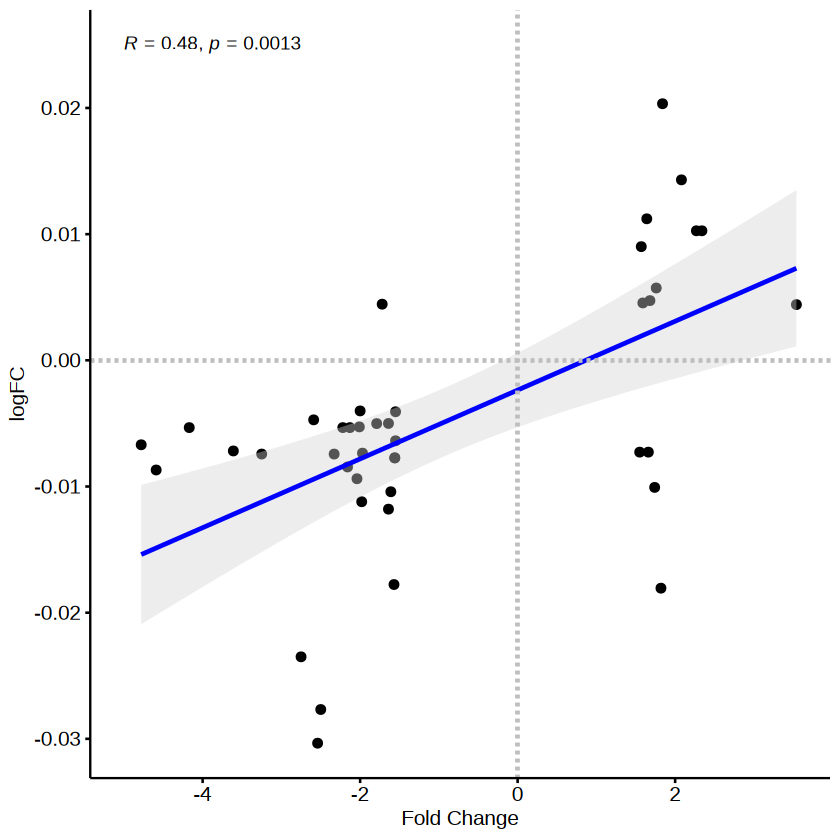

In [20]:
# Spearman correlation of fold change
# this study: logFC per year
# Lu et al.: Fold Change btw young and old individuals
colnames(Lu_Age_genes_mapped)[which(names(Lu_Age_genes_mapped) == 'ENSEMBL')] <- 'ensembl'

combined2 <- merge(Lu_Age_genes_mapped, DE_genes_FDR0.05, by='ensembl')

sp <- ggscatter(combined2, x = "Fold Change", y = "logFC",
   add = "reg.line",  # Add regressin line
   add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
   conf.int = TRUE # Add confidence interval
   )
# Add correlation coefficient
sp + stat_cor(method = "spearman", label.x = -5, label.y = 0.025) + 
geom_hline(yintercept=0, linetype="dashed", color = "grey", linewidth=1) + 
geom_vline(xintercept=0, linetype="dashed", color = "grey", linewidth=1)

# SessionInfo

In [21]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] hgu95av2.db_3.13.0          biomaRt_2.58.0             
 [3] ggpubr_0.6.0                GeneOverlap_1.38.0         
 [5] writexl_1.4.2               readxl_1.4.3               
 [7]